In [1]:
# Import the necessary libraries for data manipulation, visualization, and model building
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2


In [2]:
# Define paths to the directories containing the train and test datasets
train_dir = 'CU Boulder/Intro to Deep Learning/Week 3/Cancer Detection Project/Data/train'
test_dir = 'CU Boulder/Intro to Deep Learning/Week 3/Cancer Detection Project/Data/test'

# Load train labels from CSV file
train_labels = pd.read_csv('CU Boulder/Intro to Deep Learning/Week 3/Cancer Detection Project/Data/train_labels.csv')

# Display basic information about the train labels dataframe
print("Training Labels Info:")
print(train_labels.info())
print("\nSample of Training Labels:")
print(train_labels.head())

Training Labels Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

Sample of Training Labels:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


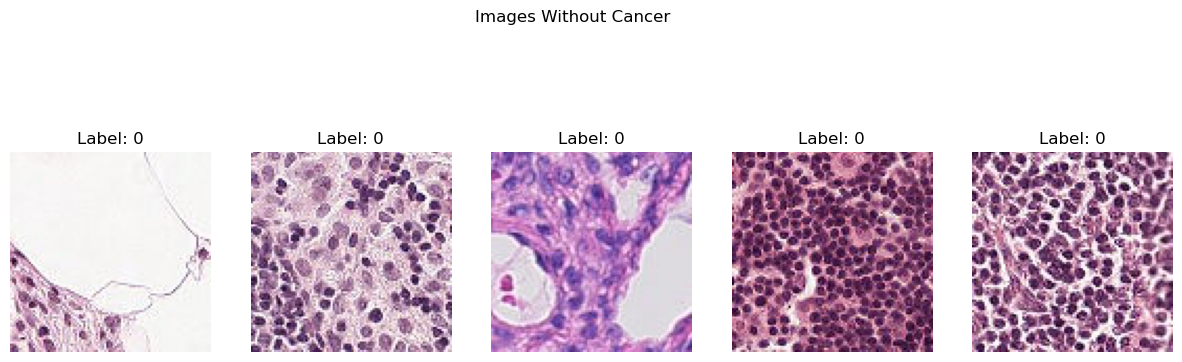

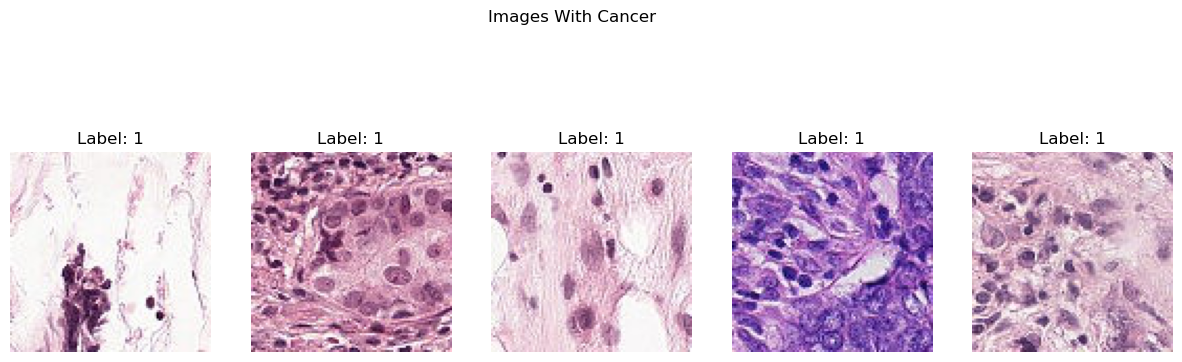

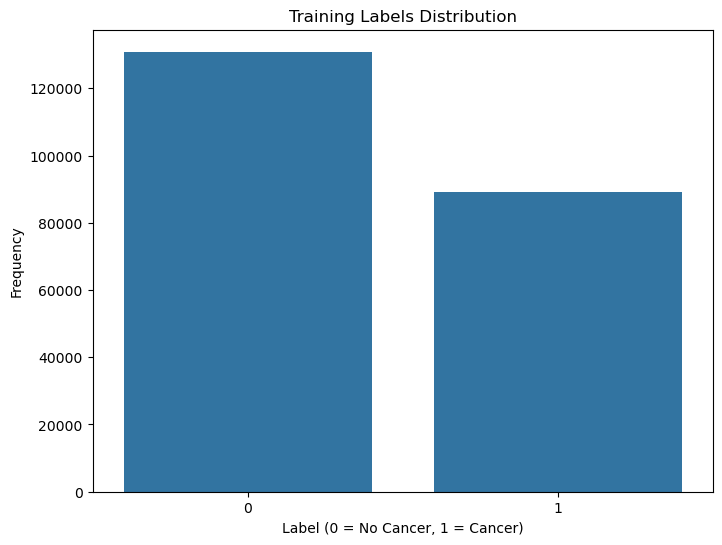

In [3]:
# Function to display images with their respective labels
def display_images(img_ids, labels, path, title):
    """
    Display selected images with their labels.
    Args:
    - img_ids: List of image IDs
    - labels: Corresponding labels for the images
    - path: Directory path where images are located
    - title: Title for the plot
    """
    plt.figure(figsize=(15, 5))
    for i, (img_id, label) in enumerate(zip(img_ids, labels)):
        img_path = os.path.join(path, img_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, len(img_ids), i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Show examples with and without cancer
display_images(train_labels[train_labels['label'] == 0]['id'][:5], [0]*5, train_dir, "Images Without Cancer")
display_images(train_labels[train_labels['label'] == 1]['id'][:5], [1]*5, train_dir, "Images With Cancer")

# Analyze distribution of labels in the training dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels)
plt.title('Training Labels Distribution')
plt.xlabel('Label (0 = No Cancer, 1 = Cancer)')
plt.ylabel('Frequency')
plt.show()


In [7]:
# Rescale pixel values, split for validation, and prepare ImageDataGenerators
batch_size = 64
target_size = (60, 60)

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image pixel values
    validation_split=0.25  # Reserve a portion for validation
)

# Update 'id' column to match file names and convert 'label' to string for generator
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')
train_labels['label'] = train_labels['label'].astype(str)

# Initialize generators for train and validation datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)


Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


In [15]:
from tensorflow.keras.layers import Input

# Define the CNN architecture using Input object
model = Sequential([
    Input(shape=(60, 60, 3)),  # Define the input shape here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
model.summary()

# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=5,
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 912,961 (3.48 MB)

 Trainable params: 912,961 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7676 - loss: 0.4877

C:\Users\bendu\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2578/2578 ━━━━━━━━━━━━━━━━━━━━ 1542s 598ms/step - accuracy: 0.7676 - loss: 0.4877 - val_accuracy: 0.8368 - val_loss: 0.3749 - learning_rate: 0.0010
Epoch 2/5
   1/2578 ━━━━━━━━━━━━━━━━━━━━ 1:00 24ms/step - accuracy: 0.8281 - loss: 0.3499

C:\Users\bendu\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2578/2578 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.8281 - loss: 0.3499 - val_accuracy: 0.9000 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 3/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 1454s 564ms/step - accuracy: 0.8337 - loss: 0.3820 - val_accuracy: 0.8381 - val_loss: 0.3676 - learning_rate: 0.0010
Epoch 4/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 0s 98us/step - accuracy: 0.8125 - loss: 0.5305 - val_accuracy: 0.9333 - val_loss: 0.3382 - learning_rate: 0.0010
Epoch 5/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 1304s 506ms/step - accuracy: 0.8525 - loss: 0.3445 - val_accuracy: 0.8508 - val_loss: 0.3378 - learning_rate: 0.0010


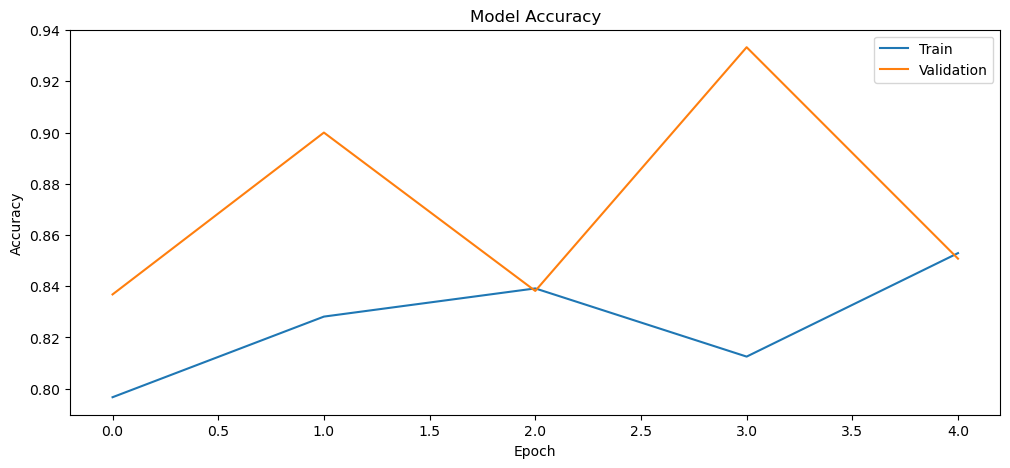

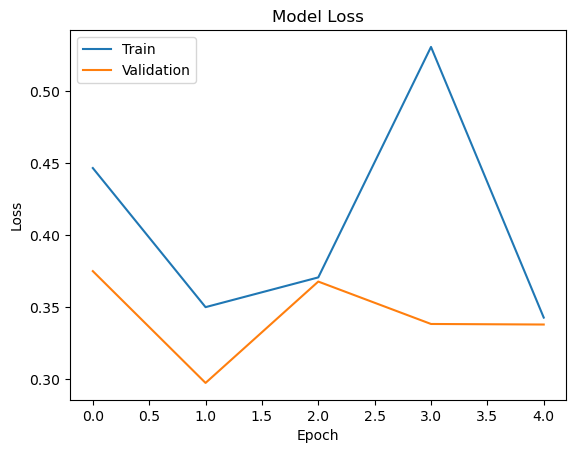

In [16]:
# Function to plot training history
import matplotlib.pyplot as plt
def plot_history(history, metric):
    """
    Plot model training history.
    Args:
    - history: Training history returned by model.fit()
    - metric: Metric to be plotted (e.g., 'accuracy', 'loss')
    """
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('Model ' + metric.title())
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

# Displaying results
plt.figure(figsize=(12, 5))
plot_history(history, 'accuracy')
plot_history(history, 'loss')

In [17]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=64,
    class_mode=None,  # Since test data has no labels
    shuffle=False
)

# Predict on test data
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Prepare the submission DataFrame
filenames = test_generator.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save submission.csv
submission_df.to_csv('submission.csv', index=False)

print("submission.csv file has been created successfully!")

Found 23044 validated image filenames.


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32,), but the yielded element was [[[[0.87843144 0.77647066 0.78823537]
   [0.97647065 0.8980393  0.9058824 ]
   [0.83921576 0.7725491  0.7960785 ]
   ...
   [0.8705883  0.7686275  0.8196079 ]
   [0.42352945 0.34117648 0.36862746]
   [0.9686275  0.8862746  0.9058824 ]]

  [[0.33333334 0.12941177 0.2784314 ]
   [0.7019608  0.5176471  0.6509804 ]
   [0.6392157  0.47058827 0.5803922 ]
   ...
   [0.9333334  0.8078432  0.8588236 ]
   [0.40784317 0.2392157  0.34509805]
   [0.5137255  0.3019608  0.4431373 ]]

  [[0.41176474 0.15686275 0.37647063]
   [0.43921572 0.19607845 0.39607847]
   [0.5529412  0.3254902  0.48627454]
   ...
   [1.         0.909804   0.9686275 ]
   [0.6039216  0.34901962 0.5058824 ]
   [0.77647066 0.4666667  0.6901961 ]]

  ...

  [[0.47058827 0.19215688 0.34901962]
   [0.8313726  0.5411765  0.6862745 ]
   [0.7254902  0.42352945 0.54901963]
   ...
   [0.43921572 0.22352943 0.37647063]
   [0.5764706  0.34901962 0.5058824 ]
   [0.3137255  0.07058824 0.22352943]]

  [[0.6        0.34509805 0.50980395]
   [0.78823537 0.52156866 0.6745098 ]
   [0.68235296 0.4039216  0.5294118 ]
   ...
   [0.59607846 0.36862746 0.5294118 ]
   [0.6        0.36078432 0.53333336]
   [0.6        0.3372549  0.5058824 ]]

  [[0.7607844  0.5372549  0.6666667 ]
   [0.73333335 0.5019608  0.6117647 ]
   [0.7686275  0.5254902  0.60784316]
   ...
   [0.26666668 0.06666667 0.227451  ]
   [0.62352943 0.4039216  0.5803922 ]
   [0.47450984 0.227451   0.39607847]]]


 [[[0.96470594 0.96470594 0.9568628 ]
   [0.9607844  0.9607844  0.95294124]
   [0.95294124 0.95294124 0.9450981 ]
   ...
   [1.         0.8470589  0.8980393 ]
   [1.         0.8352942  0.9294118 ]
   [0.8352942  0.61960787 0.73333335]]

  [[0.95294124 0.95294124 0.9450981 ]
   [0.95294124 0.95294124 0.9450981 ]
   [0.95294124 0.95294124 0.9450981 ]
   ...
   [0.9176471  0.70980394 0.7803922 ]
   [0.7372549  0.5372549  0.6117647 ]
   [0.8352942  0.6509804  0.7294118 ]]

  [[0.9607844  0.9607844  0.95294124]
   [0.95294124 0.95294124 0.9450981 ]
   [0.94117653 0.94117653 0.9333334 ]
   ...
   [0.6        0.3803922  0.4784314 ]
   [0.8941177  0.7019608  0.77647066]
   [0.82745105 0.654902   0.7058824 ]]

  ...

  [[0.12941177 0.         0.13725491]
   [0.3647059  0.20392159 0.36078432]
   [0.29411766 0.10196079 0.2784314 ]
   ...
   [0.32156864 0.1764706  0.34509805]
   [0.5058824  0.36078432 0.4901961 ]
   [0.7843138  0.6784314  0.7372549 ]]

  [[0.7254902  0.5568628  0.6666667 ]
   [0.85098046 0.6901961  0.8078432 ]
   [0.8588236  0.7058824  0.82745105]
   ...
   [0.29803923 0.14509805 0.31764707]
   [0.62352943 0.47058827 0.5764706 ]
   [1.         0.89019614 0.91372555]]

  [[0.8470589  0.67058825 0.69803923]
   [0.86666673 0.72156864 0.7490196 ]
   [0.53333336 0.43529415 0.45882356]
   ...
   [0.37647063 0.20784315 0.427451  ]
   [0.56078434 0.38431376 0.54509807]
   [0.5764706  0.43137258 0.5019608 ]]]


 [[[1.         0.854902   0.97647065]
   [0.54901963 0.35686275 0.4431373 ]
   [1.         0.85098046 0.9607844 ]
   ...
   [1.         0.909804   0.9686275 ]
   [1.         0.9725491  0.9921569 ]
   [0.67058825 0.5686275  0.5803922 ]]

  [[0.6156863  0.41176474 0.5529412 ]
   [0.87843144 0.6862745  0.7725491 ]
   [0.65882355 0.5294118  0.63529414]
   ...
   [0.1254902  0.01960784 0.14901961]
   [0.09803922 0.03137255 0.16470589]
   [0.98823535 0.9176471  1.        ]]

  [[0.4156863  0.20784315 0.30980393]
   [0.78823537 0.6117647  0.6392157 ]
   [0.91372555 0.8235295  0.854902  ]
   ...
   [0.15686275 0.         0.20000002]
   [0.20000002 0.07450981 0.21960786]
   [0.9450981  0.85098046 0.9058824 ]]

  ...

  [[0.7960785  0.60784316 0.76470596]
   [0.75294125 0.5411765  0.6745098 ]
   [0.3803922  0.20000002 0.34117648]
   ...
   [0.68235296 0.5058824  0.61960787]
   [0.28627452 0.1137255  0.2509804 ]
   [0.7137255  0.5254902  0.68235296]]

  [[1.         0.909804   1.        ]
   [0.67058825 0.3921569  0.50980395]
   [0.5568628  0.3254902  0.4431373 ]
   ...
   [0.43529415 0.2784314  0.38431376]
   [0.9960785  0.80392164 0.9215687 ]
   [0.65882355 0.42352945 0.57254905]]

  [[0.69803923 0.40000004 0.5529412 ]
   [0.7019608  0.37254903 0.5019608 ]
   [0.5686275  0.28235295 0.39607847]
   ...
   [1.         0.94117653 1.        ]
   [0.7490196  0.5294118  0.627451  ]
   [0.62352943 0.33333334 0.46274513]]]


 ...


 [[[0.8117648  0.7843138  0.8117648 ]
   [0.97647065 0.9176471  0.9450981 ]
   [0.882353   0.8000001  0.8196079 ]
   ...
   [1.         0.82745105 0.8980393 ]
   [0.909804   0.7490196  0.8117648 ]
   [0.7803922  0.627451   0.69803923]]

  [[0.9333334  0.8705883  0.91372555]
   [0.8352942  0.74509805 0.7843138 ]
   [0.8313726  0.7137255  0.75294125]
   ...
   [0.8352942  0.6666667  0.74509805]
   [0.8588236  0.69411767 0.7803922 ]
   [0.8431373  0.6784314  0.7725491 ]]

  [[0.91372555 0.78823537 0.8705883 ]
   [0.654902   0.50980395 0.5803922 ]
   [0.9843138  0.8352942  0.8941177 ]
   ...
   [0.7372549  0.5647059  0.6627451 ]
   [0.7411765  0.54901963 0.6666667 ]
   [0.7411765  0.5294118  0.6627451 ]]

  ...

  [[0.7725491  0.6509804  0.6745098 ]
   [0.8745099  0.7058824  0.7803922 ]
   [0.8745099  0.6392157  0.7725491 ]
   ...
   [0.79215693 0.6431373  0.73333335]
   [0.7843138  0.64705884 0.73333335]
   [0.90196085 0.7803922  0.8431373 ]]

  [[0.95294124 0.854902   0.8705883 ]
   [0.882353   0.7490196  0.80392164]
   [0.7568628  0.5647059  0.6784314 ]
   ...
   [1.         0.9176471  1.        ]
   [1.         0.93725497 1.        ]
   [0.8862746  0.7607844  0.8117648 ]]

  [[1.         0.93725497 0.95294124]
   [1.         0.89019614 0.9450981 ]
   [0.70980394 0.5529412  0.64705884]
   ...
   [0.98823535 0.8588236  0.9333334 ]
   [0.77647066 0.62352943 0.69411767]
   [0.61960787 0.47058827 0.5137255 ]]]


 [[[0.77647066 0.40000004 0.7843138 ]
   [0.8431373  0.5137255  0.882353  ]
   [0.8117648  0.56078434 0.86666673]
   ...
   [0.6862745  0.52156866 0.8196079 ]
   [0.5176471  0.28627452 0.6       ]
   [0.79215693 0.4784314  0.8196079 ]]

  [[0.74509805 0.4156863  0.7843138 ]
   [0.6862745  0.37647063 0.73333335]
   [0.62352943 0.3019608  0.63529414]
   ...
   [0.7058824  0.5529412  0.8705883 ]
   [0.5568628  0.32156864 0.65882355]
   [0.77647066 0.45098042 0.8117648 ]]

  [[0.6901961  0.3803922  0.7294118 ]
   [0.6901961  0.3921569  0.7372549 ]
   [0.67058825 0.3254902  0.6666667 ]
   ...
   [0.6784314  0.5254902  0.8352942 ]
   [0.6745098  0.42352945 0.75294125]
   [0.8431373  0.5058824  0.86274517]]

  ...

  [[0.77647066 0.5176471  0.7960785 ]
   [0.7960785  0.5568628  0.82745105]
   [0.76470596 0.53333336 0.8000001 ]
   ...
   [0.3529412  0.13725491 0.53333336]
   [0.4039216  0.20000002 0.5921569 ]
   [0.6392157  0.41960788 0.8000001 ]]

  [[0.7490196  0.47450984 0.7568628 ]
   [0.8000001  0.5411765  0.8313726 ]
   [0.7960785  0.5529412  0.83921576]
   ...
   [0.5176471  0.40000004 0.75294125]
   [0.4039216  0.27058825 0.6431373 ]
   [0.42352945 0.25882354 0.6509804 ]]

  [[0.75294125 0.46274513 0.7568628 ]
   [0.7411765  0.46274513 0.7686275 ]
   [0.80392164 0.5529412  0.85098046]
   ...
   [0.36862746 0.23137257 0.58431375]
   [0.40000004 0.227451   0.60784316]
   [0.4901961  0.26666668 0.6862745 ]]]


 [[[0.9450981  0.95294124 0.94117653]
   [0.9490197  0.9568628  0.9450981 ]
   [0.9607844  0.9686275  0.9568628 ]
   ...
   [0.9568628  0.9607844  0.97647065]
   [0.98823535 0.92549026 0.96470594]
   [0.9960785  0.8941177  0.9450981 ]]

  [[0.96470594 0.9725491  0.9607844 ]
   [0.9607844  0.9686275  0.9568628 ]
   [0.9607844  0.9607844  0.95294124]
   ...
   [0.96470594 0.9607844  0.95294124]
   [0.9607844  0.9176471  0.9333334 ]
   [0.854902   0.78823537 0.8117648 ]]

  [[0.9568628  0.96470594 0.95294124]
   [0.9607844  0.9607844  0.95294124]
   [0.9607844  0.9607844  0.95294124]
   ...
   [0.909804   0.86666673 0.882353  ]
   [0.909804   0.86666673 0.89019614]
   [0.9215687  0.87843144 0.909804  ]]

  ...

  [[0.9490197  0.9450981  0.93725497]
   [0.9450981  0.94117653 0.9333334 ]
   [0.9568628  0.95294124 0.9450981 ]
   ...
   [0.90196085 0.7254902  0.8078432 ]
   [0.67058825 0.49411768 0.5764706 ]
   [0.97647065 0.854902   0.9176471 ]]

  [[0.93725497 0.91372555 0.91372555]
   [0.9294118  0.91372555 0.909804  ]
   [0.96470594 0.9490197  0.9450981 ]
   ...
   [0.8078432  0.6313726  0.7137255 ]
   [1.         0.90196085 0.95294124]
   [0.90196085 0.82745105 0.85098046]]

  [[0.97647065 0.95294124 0.95294124]
   [0.9333334  0.909804   0.909804  ]
   [0.9490197  0.9333334  0.9294118 ]
   ...
   [0.8705883  0.7058824  0.7843138 ]
   [0.87843144 0.7960785  0.8235295 ]
   [0.69803923 0.654902   0.64705884]]]].
Traceback (most recent call last):

  File "C:\Users\bendu\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\bendu\anaconda3\Lib\site-packages\tensorflow\python\data\util\nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(
           ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\bendu\anaconda3\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1541, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\bendu\anaconda3\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1570, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "C:\Users\bendu\anaconda3\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1414, in _tf_data_assert_shallow_structure
    raise TypeError(

TypeError: If shallow structure is a sequence, input must also be a sequence. Input has type: 'ndarray'.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "C:\Users\bendu\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "C:\Users\bendu\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\bendu\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32,), but the yielded element was [[[[0.87843144 0.77647066 0.78823537]
   [0.97647065 0.8980393  0.9058824 ]
   [0.83921576 0.7725491  0.7960785 ]
   ...
   [0.8705883  0.7686275  0.8196079 ]
   [0.42352945 0.34117648 0.36862746]
   [0.9686275  0.8862746  0.9058824 ]]

  [[0.33333334 0.12941177 0.2784314 ]
   [0.7019608  0.5176471  0.6509804 ]
   [0.6392157  0.47058827 0.5803922 ]
   ...
   [0.9333334  0.8078432  0.8588236 ]
   [0.40784317 0.2392157  0.34509805]
   [0.5137255  0.3019608  0.4431373 ]]

  [[0.41176474 0.15686275 0.37647063]
   [0.43921572 0.19607845 0.39607847]
   [0.5529412  0.3254902  0.48627454]
   ...
   [1.         0.909804   0.9686275 ]
   [0.6039216  0.34901962 0.5058824 ]
   [0.77647066 0.4666667  0.6901961 ]]

  ...

  [[0.47058827 0.19215688 0.34901962]
   [0.8313726  0.5411765  0.6862745 ]
   [0.7254902  0.42352945 0.54901963]
   ...
   [0.43921572 0.22352943 0.37647063]
   [0.5764706  0.34901962 0.5058824 ]
   [0.3137255  0.07058824 0.22352943]]

  [[0.6        0.34509805 0.50980395]
   [0.78823537 0.52156866 0.6745098 ]
   [0.68235296 0.4039216  0.5294118 ]
   ...
   [0.59607846 0.36862746 0.5294118 ]
   [0.6        0.36078432 0.53333336]
   [0.6        0.3372549  0.5058824 ]]

  [[0.7607844  0.5372549  0.6666667 ]
   [0.73333335 0.5019608  0.6117647 ]
   [0.7686275  0.5254902  0.60784316]
   ...
   [0.26666668 0.06666667 0.227451  ]
   [0.62352943 0.4039216  0.5803922 ]
   [0.47450984 0.227451   0.39607847]]]


 [[[0.96470594 0.96470594 0.9568628 ]
   [0.9607844  0.9607844  0.95294124]
   [0.95294124 0.95294124 0.9450981 ]
   ...
   [1.         0.8470589  0.8980393 ]
   [1.         0.8352942  0.9294118 ]
   [0.8352942  0.61960787 0.73333335]]

  [[0.95294124 0.95294124 0.9450981 ]
   [0.95294124 0.95294124 0.9450981 ]
   [0.95294124 0.95294124 0.9450981 ]
   ...
   [0.9176471  0.70980394 0.7803922 ]
   [0.7372549  0.5372549  0.6117647 ]
   [0.8352942  0.6509804  0.7294118 ]]

  [[0.9607844  0.9607844  0.95294124]
   [0.95294124 0.95294124 0.9450981 ]
   [0.94117653 0.94117653 0.9333334 ]
   ...
   [0.6        0.3803922  0.4784314 ]
   [0.8941177  0.7019608  0.77647066]
   [0.82745105 0.654902   0.7058824 ]]

  ...

  [[0.12941177 0.         0.13725491]
   [0.3647059  0.20392159 0.36078432]
   [0.29411766 0.10196079 0.2784314 ]
   ...
   [0.32156864 0.1764706  0.34509805]
   [0.5058824  0.36078432 0.4901961 ]
   [0.7843138  0.6784314  0.7372549 ]]

  [[0.7254902  0.5568628  0.6666667 ]
   [0.85098046 0.6901961  0.8078432 ]
   [0.8588236  0.7058824  0.82745105]
   ...
   [0.29803923 0.14509805 0.31764707]
   [0.62352943 0.47058827 0.5764706 ]
   [1.         0.89019614 0.91372555]]

  [[0.8470589  0.67058825 0.69803923]
   [0.86666673 0.72156864 0.7490196 ]
   [0.53333336 0.43529415 0.45882356]
   ...
   [0.37647063 0.20784315 0.427451  ]
   [0.56078434 0.38431376 0.54509807]
   [0.5764706  0.43137258 0.5019608 ]]]


 [[[1.         0.854902   0.97647065]
   [0.54901963 0.35686275 0.4431373 ]
   [1.         0.85098046 0.9607844 ]
   ...
   [1.         0.909804   0.9686275 ]
   [1.         0.9725491  0.9921569 ]
   [0.67058825 0.5686275  0.5803922 ]]

  [[0.6156863  0.41176474 0.5529412 ]
   [0.87843144 0.6862745  0.7725491 ]
   [0.65882355 0.5294118  0.63529414]
   ...
   [0.1254902  0.01960784 0.14901961]
   [0.09803922 0.03137255 0.16470589]
   [0.98823535 0.9176471  1.        ]]

  [[0.4156863  0.20784315 0.30980393]
   [0.78823537 0.6117647  0.6392157 ]
   [0.91372555 0.8235295  0.854902  ]
   ...
   [0.15686275 0.         0.20000002]
   [0.20000002 0.07450981 0.21960786]
   [0.9450981  0.85098046 0.9058824 ]]

  ...

  [[0.7960785  0.60784316 0.76470596]
   [0.75294125 0.5411765  0.6745098 ]
   [0.3803922  0.20000002 0.34117648]
   ...
   [0.68235296 0.5058824  0.61960787]
   [0.28627452 0.1137255  0.2509804 ]
   [0.7137255  0.5254902  0.68235296]]

  [[1.         0.909804   1.        ]
   [0.67058825 0.3921569  0.50980395]
   [0.5568628  0.3254902  0.4431373 ]
   ...
   [0.43529415 0.2784314  0.38431376]
   [0.9960785  0.80392164 0.9215687 ]
   [0.65882355 0.42352945 0.57254905]]

  [[0.69803923 0.40000004 0.5529412 ]
   [0.7019608  0.37254903 0.5019608 ]
   [0.5686275  0.28235295 0.39607847]
   ...
   [1.         0.94117653 1.        ]
   [0.7490196  0.5294118  0.627451  ]
   [0.62352943 0.33333334 0.46274513]]]


 ...


 [[[0.8117648  0.7843138  0.8117648 ]
   [0.97647065 0.9176471  0.9450981 ]
   [0.882353   0.8000001  0.8196079 ]
   ...
   [1.         0.82745105 0.8980393 ]
   [0.909804   0.7490196  0.8117648 ]
   [0.7803922  0.627451   0.69803923]]

  [[0.9333334  0.8705883  0.91372555]
   [0.8352942  0.74509805 0.7843138 ]
   [0.8313726  0.7137255  0.75294125]
   ...
   [0.8352942  0.6666667  0.74509805]
   [0.8588236  0.69411767 0.7803922 ]
   [0.8431373  0.6784314  0.7725491 ]]

  [[0.91372555 0.78823537 0.8705883 ]
   [0.654902   0.50980395 0.5803922 ]
   [0.9843138  0.8352942  0.8941177 ]
   ...
   [0.7372549  0.5647059  0.6627451 ]
   [0.7411765  0.54901963 0.6666667 ]
   [0.7411765  0.5294118  0.6627451 ]]

  ...

  [[0.7725491  0.6509804  0.6745098 ]
   [0.8745099  0.7058824  0.7803922 ]
   [0.8745099  0.6392157  0.7725491 ]
   ...
   [0.79215693 0.6431373  0.73333335]
   [0.7843138  0.64705884 0.73333335]
   [0.90196085 0.7803922  0.8431373 ]]

  [[0.95294124 0.854902   0.8705883 ]
   [0.882353   0.7490196  0.80392164]
   [0.7568628  0.5647059  0.6784314 ]
   ...
   [1.         0.9176471  1.        ]
   [1.         0.93725497 1.        ]
   [0.8862746  0.7607844  0.8117648 ]]

  [[1.         0.93725497 0.95294124]
   [1.         0.89019614 0.9450981 ]
   [0.70980394 0.5529412  0.64705884]
   ...
   [0.98823535 0.8588236  0.9333334 ]
   [0.77647066 0.62352943 0.69411767]
   [0.61960787 0.47058827 0.5137255 ]]]


 [[[0.77647066 0.40000004 0.7843138 ]
   [0.8431373  0.5137255  0.882353  ]
   [0.8117648  0.56078434 0.86666673]
   ...
   [0.6862745  0.52156866 0.8196079 ]
   [0.5176471  0.28627452 0.6       ]
   [0.79215693 0.4784314  0.8196079 ]]

  [[0.74509805 0.4156863  0.7843138 ]
   [0.6862745  0.37647063 0.73333335]
   [0.62352943 0.3019608  0.63529414]
   ...
   [0.7058824  0.5529412  0.8705883 ]
   [0.5568628  0.32156864 0.65882355]
   [0.77647066 0.45098042 0.8117648 ]]

  [[0.6901961  0.3803922  0.7294118 ]
   [0.6901961  0.3921569  0.7372549 ]
   [0.67058825 0.3254902  0.6666667 ]
   ...
   [0.6784314  0.5254902  0.8352942 ]
   [0.6745098  0.42352945 0.75294125]
   [0.8431373  0.5058824  0.86274517]]

  ...

  [[0.77647066 0.5176471  0.7960785 ]
   [0.7960785  0.5568628  0.82745105]
   [0.76470596 0.53333336 0.8000001 ]
   ...
   [0.3529412  0.13725491 0.53333336]
   [0.4039216  0.20000002 0.5921569 ]
   [0.6392157  0.41960788 0.8000001 ]]

  [[0.7490196  0.47450984 0.7568628 ]
   [0.8000001  0.5411765  0.8313726 ]
   [0.7960785  0.5529412  0.83921576]
   ...
   [0.5176471  0.40000004 0.75294125]
   [0.4039216  0.27058825 0.6431373 ]
   [0.42352945 0.25882354 0.6509804 ]]

  [[0.75294125 0.46274513 0.7568628 ]
   [0.7411765  0.46274513 0.7686275 ]
   [0.80392164 0.5529412  0.85098046]
   ...
   [0.36862746 0.23137257 0.58431375]
   [0.40000004 0.227451   0.60784316]
   [0.4901961  0.26666668 0.6862745 ]]]


 [[[0.9450981  0.95294124 0.94117653]
   [0.9490197  0.9568628  0.9450981 ]
   [0.9607844  0.9686275  0.9568628 ]
   ...
   [0.9568628  0.9607844  0.97647065]
   [0.98823535 0.92549026 0.96470594]
   [0.9960785  0.8941177  0.9450981 ]]

  [[0.96470594 0.9725491  0.9607844 ]
   [0.9607844  0.9686275  0.9568628 ]
   [0.9607844  0.9607844  0.95294124]
   ...
   [0.96470594 0.9607844  0.95294124]
   [0.9607844  0.9176471  0.9333334 ]
   [0.854902   0.78823537 0.8117648 ]]

  [[0.9568628  0.96470594 0.95294124]
   [0.9607844  0.9607844  0.95294124]
   [0.9607844  0.9607844  0.95294124]
   ...
   [0.909804   0.86666673 0.882353  ]
   [0.909804   0.86666673 0.89019614]
   [0.9215687  0.87843144 0.909804  ]]

  ...

  [[0.9490197  0.9450981  0.93725497]
   [0.9450981  0.94117653 0.9333334 ]
   [0.9568628  0.95294124 0.9450981 ]
   ...
   [0.90196085 0.7254902  0.8078432 ]
   [0.67058825 0.49411768 0.5764706 ]
   [0.97647065 0.854902   0.9176471 ]]

  [[0.93725497 0.91372555 0.91372555]
   [0.9294118  0.91372555 0.909804  ]
   [0.96470594 0.9490197  0.9450981 ]
   ...
   [0.8078432  0.6313726  0.7137255 ]
   [1.         0.90196085 0.95294124]
   [0.90196085 0.82745105 0.85098046]]

  [[0.97647065 0.95294124 0.95294124]
   [0.9333334  0.909804   0.909804  ]
   [0.9490197  0.9333334  0.9294118 ]
   ...
   [0.8705883  0.7058824  0.7843138 ]
   [0.87843144 0.7960785  0.8235295 ]
   [0.69803923 0.654902   0.64705884]]]].


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 